(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import libraries for scientific computing
import numpy as np
import scipy as sp
import pandas as pd

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the context for the plots
sns.set_context("notebook")
# Set the style for the plots
sns.set_style("darkgrid")
# Set default color palette to colorblind
sns.set_palette("colorblind")

# Metropolis-Hastings algorithm

In this notebook, we will implement the first MCMC algorithm ever proposed, the
so-called Metropolis-Hastings algorithm. This algorithm helps allows us to
approximate the posterior distribution of a model via smart sampling.

The steps of the algorithm are as follows:

1. Start at an arbitrary point in the parameter space $\theta_t$.
2. Propose a new point in the parameter space using a proposal distribution
   $\theta'$. Usually, this is a normal distribution centered at the current
   point, where the variance of the distribution is a parameter of the algorithm
   (sometimes called the step size).
3. Calculate the Metropolis-Hastings ratio $\alpha$ (to be defined later) to
   decide whether to accept or reject the proposed point.
4. Accept or reject the proposed point based on the Metropolis-Hastings ratio.
    - Generate a random number $u$ from a uniform distribution between 0 and 1.
    - If $u \leq \alpha$, accept the proposed point. $\theta_{t+1} = \theta'$.
    - If $u > \alpha$, reject the proposed point. $\theta_{t+1} = \theta_t$.

We will not go through the formal proof for why this procedure is guaranteed to
converge to the posterior distribution. However, we will show that it works in
practice. The Metropolis-Hastings ratio is defined as
$$
\alpha(\theta' \mid \theta) = \min
\left(1, \frac{P(\theta' | D)}{P(\theta | D)}\right).
\tag{1}
$$

Intuitively, we can see that if $\theta'$ goes uphill in the posterior, i.e.,
climbs up to a more likely value, the ratio of the posterior probabilities
$P(\theta' | D) / P(\theta | D)$ will be greater than 1, and the proposed point
will be accepted. If $\theta'$ goes downhill, the ratio will be less than 1, and
then we flip a biased coin to decide whether to accept the point. Although we
cannot evaluate the posterior to compute the ratio, we can evaluate the
unnormalized version, which is proportional to the posterior. Therefore, the
normalizing constant cancels out in the ratio.

Let's write a function that implements the Metropolis-Hastings algorithm. First,
we define a function for a single Metropolis-Hastings step.

In [3]:
def mh_step(theta, log_post, log_post_args, sigma=1E-3):
    """
    Perform one Metropolis-Hastings step.

    Parameters
    ----------
    theta : array_like
        The current parameter values.
    log_post : callable
        The function to compute the log posterior.
    log_post_args : tuple
        The arguments to pass to log_post
    sigma : float
        The standard deviation of the proposal distribution.
    """
    # Generate a candidate from the proposal distribution
    theta_p = theta + np.random.normal(0, sigma, len(theta))

    # Compute the log posterior at the candidate values
    log_post_p = log_post(theta_p, *log_post_args)

    # Compute the log of the ratio of the posteriors
    log_alpha = log_post_p - log_post(theta, *log_post_args)

    # Accept or reject the candidate
    if np.log(np.random.rand()) <= log_alpha:
        return theta_p
    else:
        return theta

Next, we will define a function that runs the Metropolis-Hastings algorithm for
a given number of steps.

In [4]:
def mcmc_mh(log_post, log_post_args, theta0, niter, sigma=1E-3):
    """
    Perform a Metropolis-Hastings MCMC simulation.

    Parameters
    ----------
    log_post : callable
        The function to compute the log posterior.
    log_post_args : tuple
        The arguments to pass to log_post
    theta0 : array_like
        The initial parameter values.
    niter : int
        The number of iterations to perform.
    sigma : float
        The standard deviation of the proposal distribution.

    Returns
    -------
    chain : ndarray
        The parameter values at each iteration.
    """
    # Initialize array to store the samples
    theta_chain = np.zeros((niter, len(theta0)))

    # Initialize the current parameter values
    theta_chain[0] = theta0

    # Loop over the iterations
    for i in range(1, niter):
        theta_chain[i] = mh_step(
            theta_chain[i-1], log_post, log_post_args, sigma
        )

    return theta_chain

We are ready to test the Metropolis-Hastings algorithm. For simplicity, we will
copy the log_posterior function that we wrote in the previous notebook.

In [5]:
def log_posterior(p, data, alpha, beta):
    """
    Compute the log posterior of the beta-binomial model.

    Arguments:
    p : float in [0, 1], probability of reversal.
    data : 2D array, first column is the number of trials, second column is the
    number of reversals.
    alpha : float, shape parameter of the prior beta distribution.
    beta : float, shape parameter of the prior beta distribution.

    Returns:
    log_post : float, unnormalized log posterior of the beta-binomial model
    """
    # Extract the number of trials and the number of reversals
    trials = data[:, 0]
    reversals = data[:, 1]

    # Compute the log likelihood
    log_like = sum([
        sp.stats.binom.logpmf(r, n, p) for r, n in zip(reversals, trials)
    ])

    # Compute the log prior
    log_prior = sp.stats.beta.logpdf(p, a=alpha, b=beta)

    # Compute the log posterior
    log_post = log_like + log_prior

    return log_post

Now, let's load the data.

In [6]:
# Load data as a pandas dataframe
df = pd.read_csv('./data/boolean_data.csv')

df.head()

,Strain,Year,Trials,Reversals
0,WT,2017,55,7
1,ASH,2017,54,18
2,AVA,2017,52,28
3,WT,2016,36,6
4,ASH,2016,35,12


Let's first test the single Metropolis-Hastings step function.

In [10]:
# Define the data
data_ash = df[(df.Strain == 'ASH')][['Trials', 'Reversals']].values

# Define values of alpha and beta for the prior
alpha = 1
beta = 1

# Define the initial parameter values
theta0 = np.array([0.5])

# Collect log_post_args
log_post_args = (data_ash, alpha, beta)

# Test single step
mh_step(theta0, log_posterior, log_post_args)

array([0.50093803])

Seems to be working. Let's now test the full Metropolis-Hastings algorithm with
several steps.

In [18]:
# Define number of iterations
n_iter = 50_000

# Run MCMC
p_chain = mcmc_mh(log_posterior, log_post_args, theta0, n_iter, sigma=1E-2)

Let's look at a histogram of the samples.

Text(0, 0.5, 'frequency')

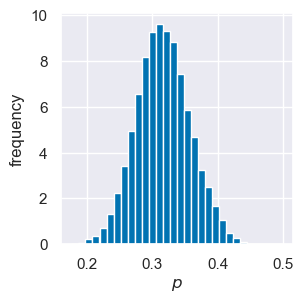

In [22]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Plot the chain normed histogram
ax.hist(p_chain, bins=30, density=True)

# Label the axes
ax.set_xlabel(r'$p$')
ax.set_ylabel('frequency')

This looks pretty similar to the posterior distribution that we obtained using
numerical integration. To make sure that is the case, let's compare the two. For
this, we will copy the code from the previous tutorial to compute the normalized
posterior.

In [23]:
def log_posterior_norm(p, data, alpha, beta):
    """
    Compute the normalized log posterior of the beta-binomial model.

    Arguments:
    p : array of float in [0, 1], probability of reversal.
    data : 2D array, first column is the number of trials, second column is the
    number of reversals.
    alpha : float, shape parameter of the prior beta distribution.
    beta : float, shape parameter of the prior beta distribution.

    Returns:
    log_post : float, normalized log posterior of the beta-binomial model
    """
    # Extract the number of trials and the number of reversals
    trials = data[:, 0]
    reversals = data[:, 1]

    # Compute the log likelihood
    log_like = [
        sum([
            sp.stats.binom.logpmf(r, n, p_i) for r, n in zip(reversals, trials)
        ]) for p_i in p
    ]

    # Compute the log prior
    log_prior = sp.stats.beta.logpdf(p, a=alpha, b=beta)

    # Compute the log posterior
    log_post = log_like + log_prior

    # Compute the log marginal likelihood
    log_marg_like = np.log(np.trapz(np.exp(log_post), p))

    # Compute the normalized log posterior
    log_post_norm = log_post - log_marg_like

    return log_post_norm

Now, we can plot both the histogram and the normalized posterior.

Text(0, 0.5, 'frequency')

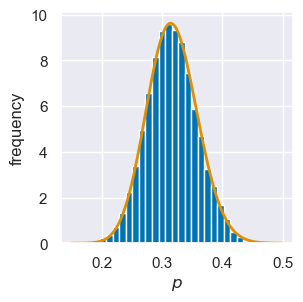

In [26]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Plot the chain normed histogram
ax.hist(p_chain, bins=30, density=True)

# Define range of x values
p = np.linspace(0.15, 0.5, 200)

# Compute the log posterior
log_post = log_posterior_norm(p, *log_post_args)

# Plot the posterior
ax.plot(p, np.exp(log_post), linewidth=2)

# Label the axes
ax.set_xlabel(r'$p$')
ax.set_ylabel('frequency')

Indeed! The two distributions are very similar. This shows that the MCMC method
works to approximate the posterior distribution of a model.

# Conclusion

In this simple example, we have shown how to implement the Metropolis-Hastings
and compare it with the numerical integration method. We have shown that the
Metropolis-Hastings algorithm works to approximate the posterior distribution of
a model. This is the first MCMC algorithm ever proposed and is still widely used
today. However, it comes with some drawbacks, especially when the dimensionality
of the parameter space is high. For that, modern methods such as Hamiltonian
Monte Carlo (HMC) and No-U-Turn Sampler (NUTS) have been developed. Although
these algorithms are out of the scope for the course, we encourage you to
explore them if you are interested in MCMC methods.

In [27]:
%load_ext watermark
%watermark -v -p numpy,scipy,pandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.22.2

numpy     : 1.26.4
scipy     : 1.12.0
pandas    : 2.2.1
matplotlib: 3.8.3
seaborn   : 0.13.2

